<a href="https://colab.research.google.com/github/AlejandroTL/OpenData/blob/main/OD_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Knowledge Graph Embeddings**

## Imports and setup

Now we will first install and import all needed libraries. We will use AmpliGraph.

In [ ]:
%tensorflow_version 1.15.3

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.15.3`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf 

print('TensorFlow  version: {}'.format(tf.__version__))


TensorFlow  version: 1.15.2


In [ ]:
%%capture 
# Install AmpliGraph library
! pip install ampligraph

# Required to visualize embeddings with tensorboard projector, comment out if not required!
! pip install --user tensorboard

# Required to plot text on embedding clusters, comment out if not required!
! pip install --user git+https://github.com/Phlya/adjustText

In [ ]:
%tensorflow_version 1.x
import ampligraph
import numpy as np
import pandas as pd
import tensorflow as tf
from ampligraph.datasets import load_fb15k_237
from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.discovery import query_topn, discover_facts, find_clusters
from ampligraph.latent_features import TransE, ComplEx, HolE, DistMult, ConvE, ConvKB
from ampligraph.utils import save_model, restore_model

from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def display_aggregate_metrics(ranks):
    print('Mean Rank:', mr_score(ranks)) 
    print('Mean Reciprocal Rank:', mrr_score(ranks)) 
    print('Hits@1:', hits_at_n_score(ranks, 1))
    print('Hits@10:', hits_at_n_score(ranks, 10))
    print('Hits@100:', hits_at_n_score(ranks, 100))

print('Ampligraph version: {}'.format(ampligraph.__version__))

Ampligraph version: 1.4.0


## Loading a Knowledge Graph Dataset

We will use the FIFA 19 Dataset. It is public on Kaggle (https://www.kaggle.com/karangadiya/fifa19?select=data.csv) and contains detailed attributes of each player in the game. 

As the data is in tabular format, we first need to convert it to a Knowledge Graph. To do so, we will first remove some of the features (there are 89).



In [ ]:
df = pd.read_csv("data.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.shape

(18207, 89)

In [ ]:
df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,Work Rate,Body Type,Real Face,Position,Jersey Number,Joined,Loaned From,Contract Valid Until,Height,Weight,LS,ST,RS,LW,LF,CF,RF,RW,LAM,CAM,RAM,LM,...,LB,LCB,CB,RCB,RB,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,€110.5M,€565K,2202,Left,5.0,4.0,4.0,Medium/ Medium,Messi,Yes,RF,10.0,"Jul 1, 2004",NaN,2021,5'7,159lbs,88+2,88+2,88+2,92+2,93+2,93+2,93+2,92+2,93+2,93+2,93+2,91+2,...,59+2,47+2,47+2,47+2,59+2,84.0,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,91.0,86.0,91.0,95.0,95.0,85.0,68.0,72.0,59.0,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,€77M,€405K,2228,Right,5.0,4.0,5.0,High/ Low,C. Ronaldo,Yes,ST,7.0,"Jul 10, 2018",NaN,2022,6'2,183lbs,91+3,91+3,91+3,89+3,90+3,90+3,90+3,89+3,88+3,88+3,88+3,88+3,...,61+3,53+3,53+3,53+3,61+3,84.0,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,89.0,91.0,87.0,96.0,70.0,95.0,95.0,88.0,79.0,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,€118.5M,€290K,2143,Right,5.0,5.0,5.0,High/ Medium,Neymar,Yes,LW,10.0,"Aug 3, 2017",NaN,2022,5'9,150lbs,84+3,84+3,84+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,89+3,88+3,...,60+3,47+3,47+3,47+3,60+3,79.0,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,94.0,90.0,96.0,94.0,84.0,80.0,61.0,81.0,49.0,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,€72M,€260K,1471,Right,4.0,3.0,1.0,Medium/ Medium,Lean,Yes,GK,1.0,"Jul 1, 2011",NaN,2020,6'4,168lbs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17.0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,57.0,58.0,60.0,90.0,43.0,31.0,67.0,43.0,64.0,12.0,38.0,30.0,12.0,68.0,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,€102M,€355K,2281,Right,4.0,5.0,4.0,High/ High,Normal,Yes,RCM,7.0,"Aug 30, 2015",NaN,2023,5'11,154lbs,82+3,82+3,82+3,87+3,87+3,87+3,87+3,87+3,88+3,88+3,88+3,88+3,...,73+3,66+3,66+3,66+3,73+3,93.0,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,78.0,76.0,79.0,91.0,77.0,91.0,63.0,90.0,75.0,91.0,76.0,61.0,87.0,94.0,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [ ]:
df.columns

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [ ]:
features = ['ID','Name','Age','Nationality','Overall','Club','Preferred Foot','International Reputation', 'Position','Weak Foot','Finishing','ShortPassing','HeadingAccuracy','Dribbling','BallControl','ShotPower']

In [ ]:
df_features = df[features]
df_features.head()

,ID,Name,Age,Nationality,Overall,Club,Preferred Foot,International Reputation,Position,Weak Foot,Finishing,ShortPassing,HeadingAccuracy,Dribbling,BallControl,ShotPower
0,158023,L. Messi,31,Argentina,94,FC Barcelona,Left,5.0,RF,4.0,95.0,90.0,70.0,97.0,96.0,85.0
1,20801,Cristiano Ronaldo,33,Portugal,94,Juventus,Right,5.0,ST,4.0,94.0,81.0,89.0,88.0,94.0,95.0
2,190871,Neymar Jr,26,Brazil,92,Paris Saint-Germain,Right,5.0,LW,5.0,87.0,84.0,62.0,96.0,95.0,80.0
3,193080,De Gea,27,Spain,91,Manchester United,Right,4.0,GK,3.0,13.0,50.0,21.0,18.0,42.0,31.0
4,192985,K. De Bruyne,27,Belgium,91,Manchester City,Right,4.0,RCM,5.0,82.0,92.0,55.0,86.0,91.0,91.0


In [ ]:
total_data = df_features.dropna()

print("Final dimensions: ", total_data.shape)

Final dimensions:  (17918, 16)


It's still too much data. We finally work with a dataset of 1000 players and 16 features. 


### Knowledge Graph Creation

We need to encode the data in tabular form in triplestores in the form <s,p,o>. To do this, we will create relationships between the entities. In this case, there's a reification using the concept of Player to create n-ary relationship between all the features of a player.

Now we create the triples that relate the entities.

In [ ]:
triples = []
for _, row in total_data[0:10000].iterrows():
  
  # Demographic data
  player_name = (row["Name"], "playerIDIs", row["ID"])
  player_age = (row["Name"], "playerAgeIs", row["Age"])
  player_nationality = (row["Name"], "playerNationalityIs", row["Nationality"])
  player_club = (row["Name"], "currentClubIs", row["Club"])
  player_reputation = (row["Name"], "internationalReputation", row["International Reputation"])

  # Football data
  player_overall = (row["Name"], "overall", row["Overall"])
  player_position = (row["Name"], "position", row["Position"])
  player_foot = (row["Name"], "preferredFoot", row["Preferred Foot"])
  player_weak = (row["Name"], "weakFoot", row["Weak Foot"])
  player_finishing = (row["Name"], "finishingScore", row["Finishing"])
  player_short = (row["Name"], "shortPassingScore", row["ShortPassing"])
  player_heading = (row["Name"], "headingScore", row["HeadingAccuracy"])
  player_dribbling = (row["Name"], "dribblingScore", row["Dribbling"])
  player_control = (row["Name"], "controlScore", row["BallControl"])
  player_shot = (row["Name"], "shotPower", row["ShotPower"])
  
  triples.extend((player_name, player_age, player_nationality, player_club, 
                  player_reputation, player_overall, player_position,
                  player_foot, player_weak, player_finishing, player_short, 
                  player_heading, player_dribbling, player_control, player_shot))

The Knowledge Graph is now in the form of triplestores. Let's see how it looks like for the best player in history: Cristiano Ronaldo :)

In [ ]:
triples_df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])
print("Whole knowledge graph triplestores :", triples_df.shape)
triples_df[(triples_df.subject=="Cristiano Ronaldo")]

Whole knowledge graph triplestores : (150000, 3)


,subject,predicate,object
15,Cristiano Ronaldo,playerIDIs,20801
16,Cristiano Ronaldo,playerAgeIs,33
17,Cristiano Ronaldo,playerNationalityIs,Portugal
18,Cristiano Ronaldo,currentClubIs,Juventus
19,Cristiano Ronaldo,internationalReputation,5
20,Cristiano Ronaldo,overall,94
21,Cristiano Ronaldo,position,ST
22,Cristiano Ronaldo,preferredFoot,Right
23,Cristiano Ronaldo,weakFoot,4
24,Cristiano Ronaldo,finishingScore,94


## Knowledge Graph Embeddings

We will first split again out training data in a training dataset and a validation dataset. The validation dataset will be used to test the embedding on unseen data.

First, we will use TransE model. Later, we will proceed with ComplEX model.

### TransE

In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen 

X_train, X_valid = train_test_split_no_unseen(np.array(triples), test_size=50000)

print('Train set size: ', X_train.shape)
print('Validation set size: ', X_valid.shape)

Train set size:  (100000, 3)
Validation set size:  (50000, 3)


Run the cell below to avoid the training. TransE doesn't take too much time training, but it's easier to load a trained model.

In [32]:
model = restore_model('TransE10k.pkl')

In [ ]:
from ampligraph.latent_features import TransE

model = TransE(k=150, epochs=100, eta=20, loss='multiclass_nll', 
               initializer='xavier', initializer_params={'uniform': False},
               regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
               optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
               seed= 0, batches_count= 50, verbose=True)

model.fit(X_train)

X_filter = np.concatenate([X_train, X_valid], 0)

ranks = evaluate_performance(X_valid, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

100%|██████████| 50000/50000 [18:37<00:00, 44.76it/s]


Mean Rank: 2115.32006
Mean Reciprocal Rank: 0.16908345984094492
Hits@1: 0.11059
Hits@10: 0.28838
Hits@100: 0.48505


In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.17
MR: 2115.32
Hits@10: 0.29
Hits@3: 0.18
Hits@1: 0.11


In [ ]:
from ampligraph.utils import save_model, restore_model
save_model(model, 'TransE10k.pkl')

### Visualization

Let's now visualize the embedding of different entities.

First clubs.

In [ ]:
teams = total_data[0:10000].Club.unique()
team_embeddings = dict(zip(teams, model.get_embeddings(teams)))

In [ ]:
len(team_embeddings)

632

In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in team_embeddings.values()]))
#embeddings_2d_tsne = TSNE(n_components=2).fit_transform(np.array([i for i in team_embeddings.values()]))

In [ ]:
plot_df = pd.DataFrame({"teams": teams, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1]})

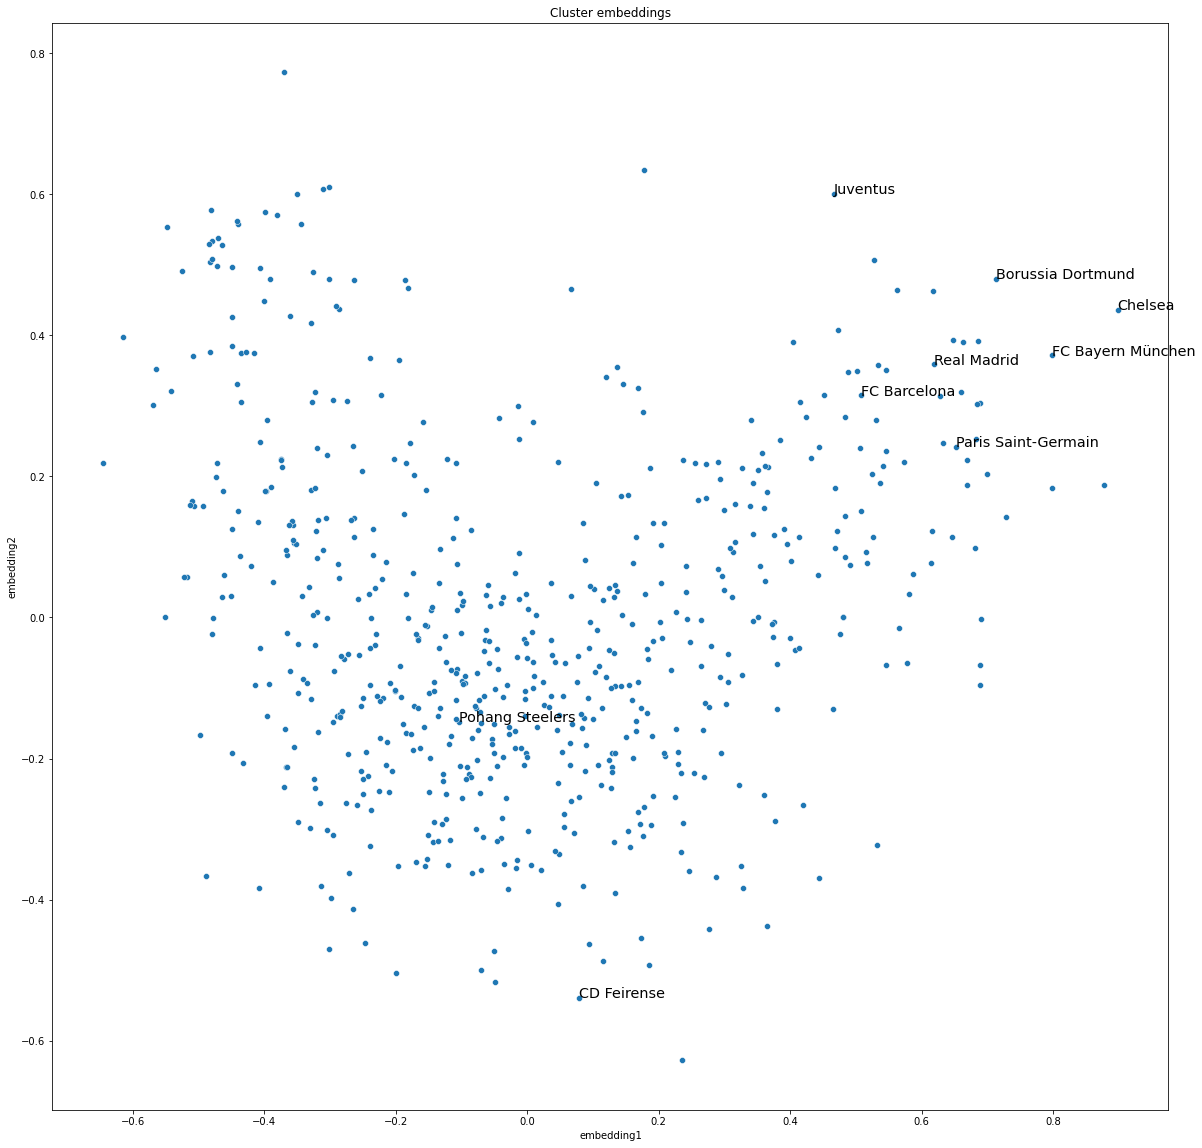

In [ ]:
topteams = ["FC Barcelona", "Juventus", "Paris Saint-Germain", "Real Madrid", 
            "Chelsea", "FC Bayern München","Borussia Dortmund",
            "CD Feirense", "Pohang Steelers"] 

plt.figure(figsize=(20, 20))
plt.title("Cluster embeddings")

ax = sns.scatterplot(data=plot_df, x="embedding1", y="embedding2")

for player in topteams:
  plt.text(plot_df.embedding1[plot_df.teams==player],plot_df.embedding2[plot_df.teams==player],player, color='black', size='x-large')

plt.show()

We see that the most successful clubs seems to be placed together. This make sense taking into account that the quality of their players should be similar.

Now we will visualize the embeddings of the players and try to find clusters. Maybe it's possible to cluster the players in three clusters of most successfulls, decent players and bad players.

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

players = total_data[0:10000].Name.unique()
players_embeddings = dict(zip(players, model.get_embeddings(players)))

embeddings_2d_players = PCA(n_components=2).fit_transform(np.array([i for i in players_embeddings.values()]))

clustering_algorithm = KMeans(n_clusters=3, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(players, model, clustering_algorithm, mode='entity')

In [ ]:
plot_df_players = pd.DataFrame({"players": players, 
                        "embedding1": embeddings_2d_players[:, 0], 
                        "embedding2": embeddings_2d_players[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})

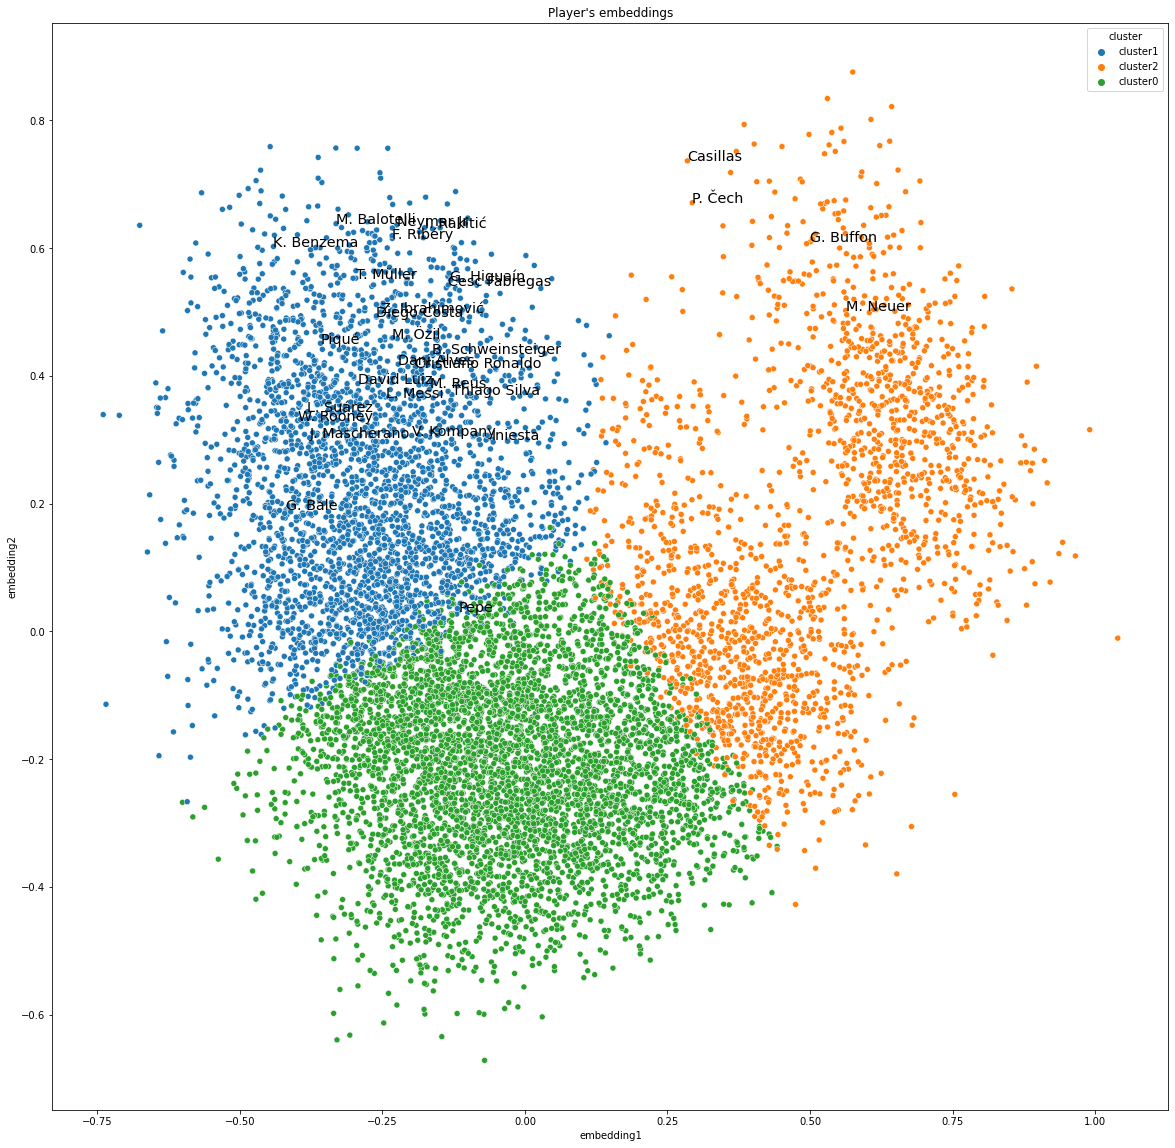

In [ ]:

topplayers = total_data[0:10000].sort_values('International Reputation', ascending=False)[0:30].Name

plt.figure(figsize=(20, 20))
plt.title("Player's embeddings")

ax = sns.scatterplot(data=plot_df_players, x="embedding1", y="embedding2", hue="cluster")

for player in topplayers:
  plt.text(plot_df_players.embedding1[plot_df_players.players==player],plot_df_players.embedding2[plot_df_players.players==player],player, color='black',size='x-large')

plt.show()

It seems that the embedding is placing the players with similar role in team close of each other. Neuer, Casillas and Cech are more close than other players, and all of them are goalkeepers. In the same way, most of the players are strikers are placed together too.

Its interesting also that the most successfull players seem to be in the upper mid of the projection.

### Link Prediction

Cristiano wants to leave Juventus, what is the destination that better fits with him?

In [ ]:
from ampligraph.discovery import discover_facts

triples, scores = query_topn(model, top_n=15, 
                             head='Cristiano Ronaldo', 
                             relation='currentClubIs', 
                             tail=None, 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    score = round(score,3)
    print('Score: {} \t {} '.format(score, triple))

Score: -15.989999771118164 	 ['Cristiano Ronaldo' 'currentClubIs' 'Juventus'] 
Score: -19.013999938964844 	 ['Cristiano Ronaldo' 'currentClubIs' 'Paris Saint-Germain'] 
Score: -19.184999465942383 	 ['Cristiano Ronaldo' 'currentClubIs' 'West Ham United'] 
Score: -19.72800064086914 	 ['Cristiano Ronaldo' 'currentClubIs' 'Everton'] 
Score: -19.966999053955078 	 ['Cristiano Ronaldo' 'currentClubIs' 'Chievo Verona'] 
Score: -20.045000076293945 	 ['Cristiano Ronaldo' 'currentClubIs' 'Guizhou Hengfeng FC'] 
Score: -20.197999954223633 	 ['Cristiano Ronaldo' 'currentClubIs' 'Manchester City'] 
Score: -20.58300018310547 	 ['Cristiano Ronaldo' 'currentClubIs' 'Wolverhampton Wanderers'] 
Score: -20.61199951171875 	 ['Cristiano Ronaldo' 'currentClubIs' 'SL Benfica'] 
Score: -20.628000259399414 	 ['Cristiano Ronaldo' 'currentClubIs' 'Bayer 04 Leverkusen'] 
Score: -20.67799949645996 	 ['Cristiano Ronaldo' 'currentClubIs' 'FC Bayern München'] 
Score: -20.69300079345703 	 ['Cristiano Ronaldo' 'currentC

And Neymar?

In [ ]:
from ampligraph.discovery import discover_facts

triples, scores = query_topn(model, top_n=15, 
                             head='Neymar Jr', 
                             relation='currentClubIs', 
                             tail=None, 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    score = round(score,3)
    print('Score: {} \t {} '.format(score, triple))

Score: -15.342000007629395 	 ['Neymar Jr' 'currentClubIs' 'Paris Saint-Germain'] 
Score: -19.143999099731445 	 ['Neymar Jr' 'currentClubIs' 'Chelsea'] 
Score: -19.547000885009766 	 ['Neymar Jr' 'currentClubIs' 'Juventus'] 
Score: -19.631999969482422 	 ['Neymar Jr' 'currentClubIs' 'Olympique Lyonnais'] 
Score: -19.63599967956543 	 ['Neymar Jr' 'currentClubIs' 'Villarreal CF'] 
Score: -19.81100082397461 	 ['Neymar Jr' 'currentClubIs' 'FC Barcelona'] 
Score: -19.92300033569336 	 ['Neymar Jr' 'currentClubIs' 'Ajax'] 
Score: -20.09600067138672 	 ['Neymar Jr' 'currentClubIs' 'West Ham United'] 
Score: -20.180999755859375 	 ['Neymar Jr' 'currentClubIs' 'Everton'] 
Score: -20.204999923706055 	 ['Neymar Jr' 'currentClubIs' 'Shandong Luneng TaiShan FC'] 
Score: -20.308000564575195 	 ['Neymar Jr' 'currentClubIs' 'Liverpool'] 
Score: -20.357999801635742 	 ['Neymar Jr' 'currentClubIs' 'FC Bayern München'] 
Score: -20.368999481201172 	 ['Neymar Jr' 'currentClubIs' 'Sevilla FC'] 
Score: -20.382999420

Joan Laporta, the new president, ask us who do we think is the best option to sign among the candidates he has in mind. We can use link prediction to provide some recommendations.

In [33]:
from ampligraph.discovery import discover_facts

triples, scores = query_topn(model, top_n=6, 
                             head=None, 
                             relation='currentClubIs', 
                             tail='FC Barcelona', 
                             ents_to_consider=['K. De Bruyne', 'Neymar Jr', 
                                               'R. Lewandowski', 'S. Agüero', 
                                               'K. Mbappé', 'M. Neuer'], 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    score = round(score,3)
    print('Score: {} \t {} '.format(score, triple))

Score: -19.45800018310547 	 ['K. Mbappé' 'currentClubIs' 'FC Barcelona'] 
Score: -19.81100082397461 	 ['Neymar Jr' 'currentClubIs' 'FC Barcelona'] 
Score: -20.124000549316406 	 ['K. De Bruyne' 'currentClubIs' 'FC Barcelona'] 
Score: -21.850000381469727 	 ['S. Agüero' 'currentClubIs' 'FC Barcelona'] 
Score: -21.98699951171875 	 ['R. Lewandowski' 'currentClubIs' 'FC Barcelona'] 
Score: -22.457000732421875 	 ['M. Neuer' 'currentClubIs' 'FC Barcelona'] 


It seems that here are better options than Agüero, but in the graph we are not taking into account the friendship between Agüero and Messi!

### ComplEX


Let's now visualize the embeddings using complEX algorithm. The results should be pretty similar.

In [ ]:
model_complex = restore_model('complEX10K.pkl')

In [ ]:
model_complex = ComplEx(k=150, epochs=100, eta=20, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 50, verbose=True)

model_complex.fit(X_train)

X_filter = np.concatenate([X_train, X_valid], 0)

ranks = evaluate_performance(X_valid, 
                             model=model_complex,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

Streaming output truncated to the last 5000 lines.

 95%|█████████▌| 47501/50000 [1:54:17<05:48,  7.16it/s]

 95%|█████████▌| 47502/50000 [1:54:17<05:47,  7.20it/s]

 95%|█████████▌| 47503/50000 [1:54:17<05:53,  7.06it/s]

 95%|█████████▌| 47504/50000 [1:54:17<05:48,  7.16it/s]

 95%|█████████▌| 47505/50000 [1:54:17<05:47,  7.17it/s]

 95%|█████████▌| 47506/50000 [1:54:17<05:52,  7.08it/s]

 95%|█████████▌| 47507/50000 [1:54:17<06:16,  6.63it/s]

 95%|█████████▌| 47508/50000 [1:54:18<06:15,  6.63it/s]

 95%|█████████▌| 47509/50000 [1:54:18<05:48,  7.15it/s]

 95%|█████████▌| 47510/50000 [1:54:18<05:36,  7.40it/s]

 95%|█████████▌| 47511/50000 [1:54:18<05:49,  7.13it/s]

 95%|█████████▌| 47512/50000 [1:54:18<05:47,  7.17it/s]

 95%|█████████▌| 47513/50000 [1:54:18<05:36,  7.40it/s]

 95%|█████████▌| 47514/50000 [1:54:18<05:39,  7.32it/s]

 95%|█████████▌| 47515/50000 [1:54:18<05:57,  6.96it/s]

 95%|█████████▌| 47516/50000 [1:54:19<05:49,  7.11it/s]

 95%|█████████▌| 47517/50000 [1:54:1

Mean Rank: 1712.70746
Mean Reciprocal Rank: 0.10709474659900665
Hits@1: 0.05155
Hits@10: 0.23029
Hits@100: 0.48533


In [17]:
from ampligraph.utils import save_model, restore_model
save_model(model, 'complEX10K.pkl')

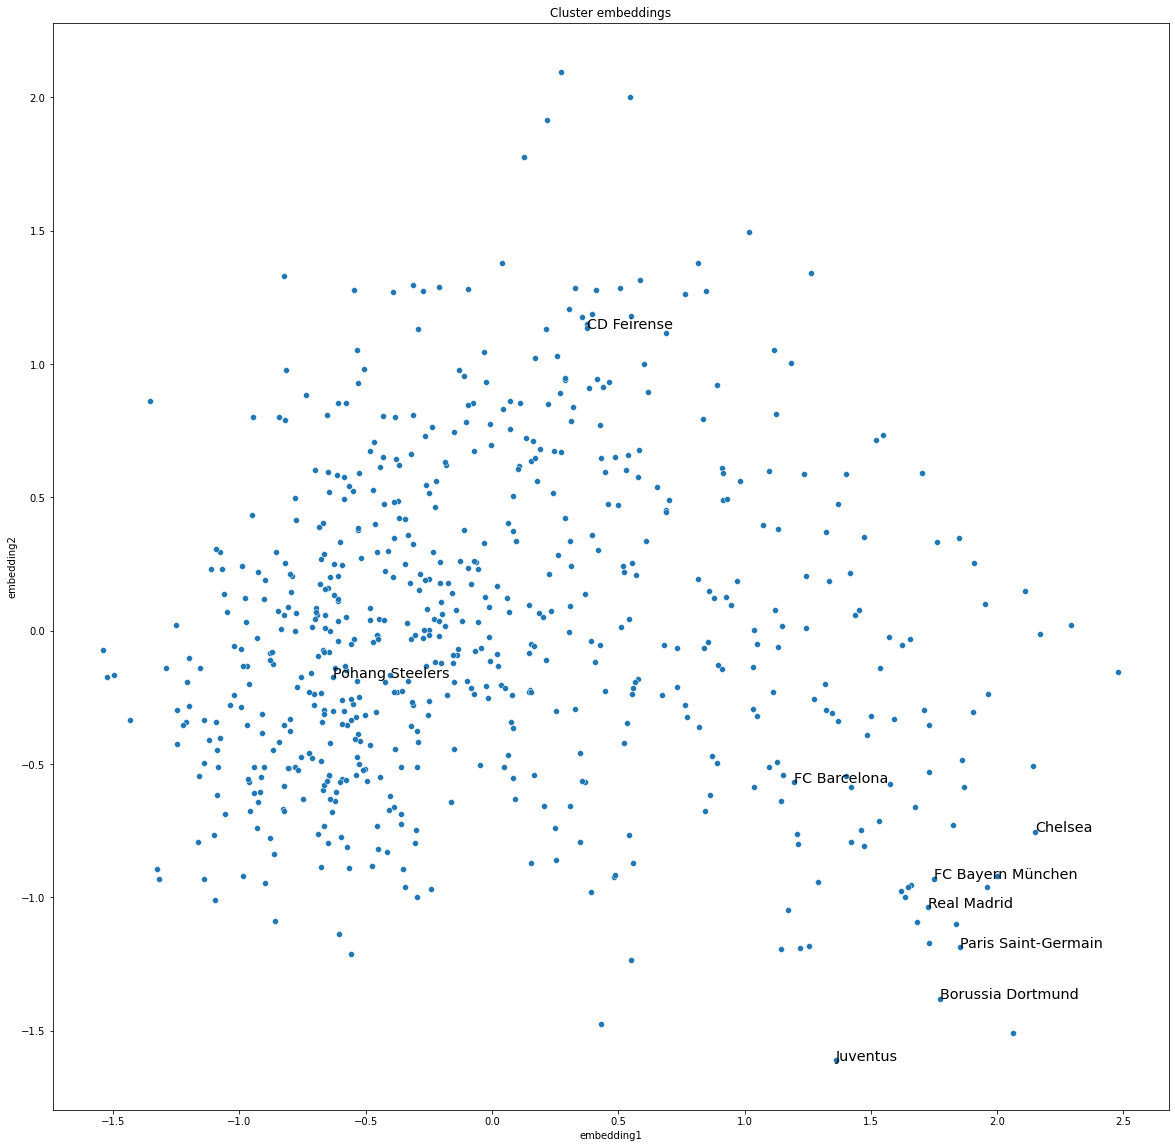

In [19]:
teams = total_data[0:10000].Club.unique()
team_embeddings = dict(zip(teams, model_complex.get_embeddings(teams)))

embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in team_embeddings.values()]))

plot_df_complex = pd.DataFrame({"teams": teams, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1]})

topteams = ["FC Barcelona", "Juventus", "Paris Saint-Germain", "Real Madrid", 
            "Chelsea", "FC Bayern München","Borussia Dortmund",
            "CD Feirense", "Pohang Steelers"] 

plt.figure(figsize=(20, 20))
plt.title("Cluster embeddings")

ax = sns.scatterplot(data=plot_df_complex, x="embedding1", y="embedding2")

for player in topteams:
  plt.text(plot_df_complex.embedding1[plot_df_complex.teams==player],plot_df_complex.embedding2[plot_df_complex.teams==player],player, color='black', size='x-large')

plt.show()

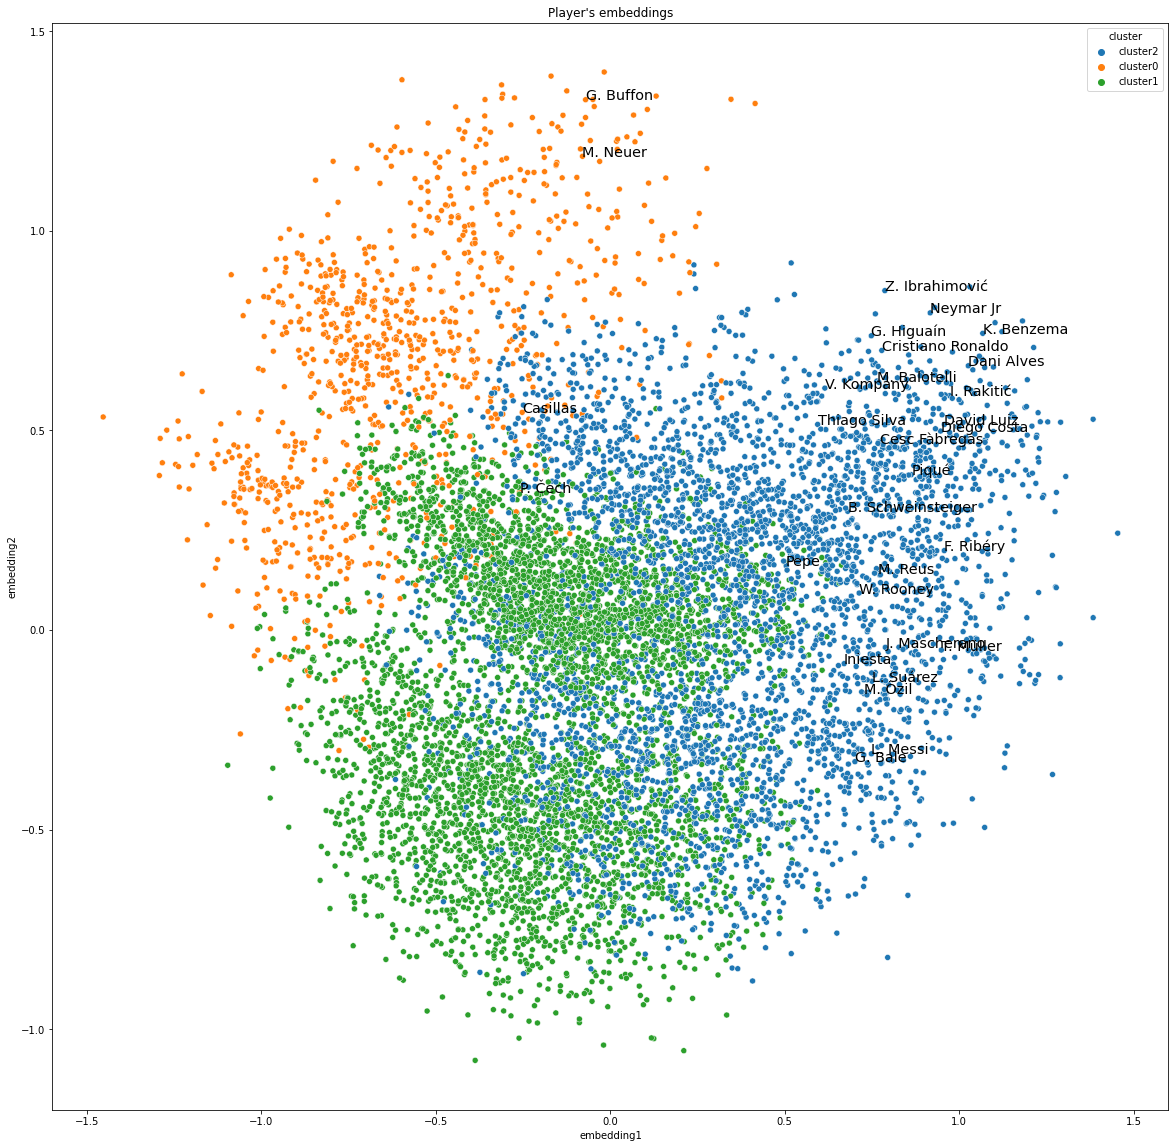

In [22]:
players = total_data[0:10000].Name.unique()
players_embeddings = dict(zip(players, model_complex.get_embeddings(players)))

embeddings_2d_players = PCA(n_components=2).fit_transform(np.array([i for i in players_embeddings.values()]))

from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

clustering_algorithm = KMeans(n_clusters=3, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(players, model_complex, clustering_algorithm, mode='entity')

plot_df_players_complex = pd.DataFrame({"players": players, 
                        "embedding1": embeddings_2d_players[:, 0], 
                        "embedding2": embeddings_2d_players[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})


topplayers = total_data[0:10000].sort_values('International Reputation', ascending=False)[0:30].Name

plt.figure(figsize=(20, 20))
plt.title("Player's embeddings")

ax = sns.scatterplot(data=plot_df_players_complex, x="embedding1", y="embedding2", hue="cluster")

for player in topplayers:
  plt.text(plot_df_players_complex.embedding1[plot_df_players_complex.players==player],plot_df_players_complex.embedding2[plot_df_players_complex.players==player],player, color='black',size='x-large')

plt.show()

In [29]:

triples, scores = query_topn(model_complex, top_n=6, 
                             head='Piqué', 
                             relation='currentClubIs', 
                             tail=None, 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    score = round(score,3)
    print('Score: {} \t {} '.format(score, triple))

Score: 14.430000305175781 	 ['Piqué' 'currentClubIs' 'FC Barcelona'] 
Score: 10.265000343322754 	 ['Piqué' 'currentClubIs' 'Olympique Lyonnais'] 
Score: 9.800000190734863 	 ['Piqué' 'currentClubIs' 'Atlético Madrid'] 
Score: 9.767999649047852 	 ['Piqué' 'currentClubIs' 'Real Valladolid CF'] 
Score: 9.680000305175781 	 ['Piqué' 'currentClubIs' 'CF Rayo Majadahonda'] 
Score: 9.515999794006348 	 ['Piqué' 'currentClubIs' 'Tigres U.A.N.L.'] 
